In [10]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from scipy.interpolate import LinearNDInterpolator
from tqdm import tqdm

In [24]:
ds = xr.open_dataset("combined_output.nc", decode_times=False)

In [ ]:
Hx= ds.Hx.values
Hz= ds.Hz.values
x = ds.x_caa[Hx+1:-Hx]
z = ds.z_aac[Hz+1:-Hz]
dx = ds.dx_caa.values
dz = ds.dz_aac.values
Lx = ds.Lx.values
Lz = ds.Lz.values
npad = 3
for var_name in ['T','b','wc']:
    ds[var_name + '_filtered_regrid'] = ds.xi_u.copy(data=np.zeros_like(ds.xi_u.values))
    for it in tqdm(range(ds.time.shape[0])):
        ds_it = ds.isel({'time':it})
        mapxr = ds_it.xi_u[Hz+1:-Hz,0,Hx+1:-Hx] + x
        mapzr = ds_it.xi_w[Hz+1:-Hz,0,Hx+1:-Hx] + z
        xx_loc = (mapxr - ds_it.xi_u[Hz+1:-Hz,0,Hx+1:-Hx]) #trick to get meshgrid of x and z
        zz_loc = (mapzr - ds_it.xi_w[Hz+1:-Hz,0,Hx+1:-Hx])
        # x is a periodic coordinate
        mapxr -= np.floor((mapxr - x[0]) / Lx) * Lx
        mapxr_ravel = np.ravel(mapxr)
        mapzr_ravel = np.ravel(mapzr)
        scalar_ravel = np.ravel(ds_it[var_name + '_filtered'][Hz+1:-Hz,0,Hx+1:-Hx])
        #Let's pad mapxr to avoid interpolation issues at the edges
        mapxr_extra = mapxr_ravel[(mapxr_ravel < -Lx/2 + dx*npad) | (mapxr_ravel > Lx/2 - dx*npad) ]
        mapzr_extra = mapzr_ravel[(mapxr_ravel < -Lx/2 + dx*npad) | (mapxr_ravel > Lx/2 - dx*npad) ]
        mapxr_extra[mapxr_extra < -Lx/2 + dx*npad] += Lx
        mapxr_extra[mapxr_extra > Lx/2 - dx*npad] -= Lx
        
        scalar_extra = scalar_ravel[(mapxr_ravel < -Lx/2 + dx*npad) | (mapxr_ravel > Lx/2 - dx*npad) ]
        
        mapxr_ravel = np.concatenate((mapxr_ravel, mapxr_extra))
        mapzr_ravel = np.concatenate((mapzr_ravel, mapzr_extra))
        scalar_ravel = np.concatenate((scalar_ravel, scalar_extra))

        interp = LinearNDInterpolator(list(zip(mapzr_ravel,mapxr_ravel)),np.ravel(scalar_ravel))
        ds[var_name + '_filtered_regrid'][it,Hz+1:-Hz,0,Hx+1:-Hx] = interp(zz_loc, xx_loc)

100%|██████████| 121/121 [00:16<00:00,  7.23it/s]


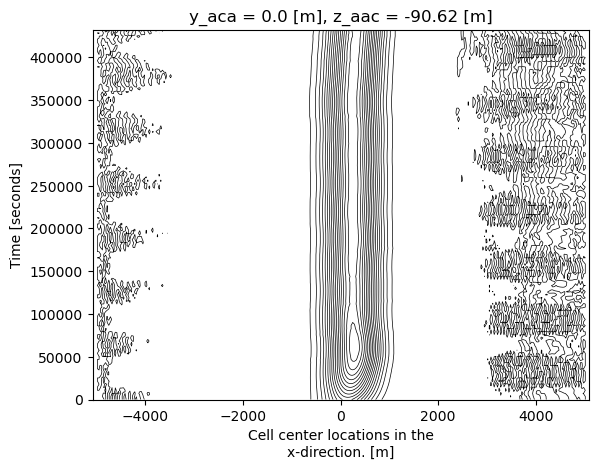

In [ ]:
ds.T_filtered_regrid[:,10,0,:].plot()
ds.T_filtered_regrid[:,10,0,:].plot.contour(levels=40, colors='k', linewidths=0.5)

In [31]:
ds.to_netcdf("combined_output_regrid.nc")